In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
sys.path.append("../..")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sceneclassification.config import *
from sceneclassification.datasets import SceneEmbeddingDataset
from sceneclassification.models.gated_fusion import GatedFusion
from sceneclassification.train import train_epoch, eval_epoch
from sceneclassification.eval import evaluate

In [5]:
torch.manual_seed(SEED)
np.random.seed(SEED)

In [6]:
# Load Data
CSV_PATH = "../data/clip_embeddings_sunrgbd_with_labels.csv"

dataset = SceneEmbeddingDataset(CSV_PATH)
num_classes = dataset.num_classes
print("Num classes:", num_classes)

Num classes: 24


## Prepare Data

In [7]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size


train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

Train samples: 1108
Val samples: 277


In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)


val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

## Model Initialization

In [9]:
model = GatedFusion(
    img_dim=IMAGE_EMB_DIM,
    depth_dim=DEPTH_EMB_DIM,
    text_dim=TEXT_EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=num_classes,
).to(DEVICE)

print(model)

GatedFusion(
  (img_gate): Linear(in_features=512, out_features=512, bias=True)
  (depth_gate): Linear(in_features=512, out_features=512, bias=True)
  (text_gate): Linear(in_features=512, out_features=512, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=1536, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=24, bias=True)
  )
)


## Training

In [10]:
# Optimizer and Loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
)

In [ ]:
train_accs, val_accs = [], []

best_val_acc = 0.0
patience = 5
counter = 0

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion, DEVICE)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0  # reset counter if validation improves
        torch.save(model.state_dict(), "../model_assets/best_model_gatedfusion.pth")  # save best model
    else:
        counter += 1
        if counter >= patience:
            print(f"No improvement in validation accuracy for {patience} epochs. Stopping early.")
            break

Epoch 1/50 | Train Acc: 0.5514 | Val Acc: 0.5895
Epoch 2/50 | Train Acc: 0.6264 | Val Acc: 0.6313
Epoch 3/50 | Train Acc: 0.7049 | Val Acc: 0.7321
Epoch 4/50 | Train Acc: 0.7789 | Val Acc: 0.7912
Epoch 5/50 | Train Acc: 0.8357 | Val Acc: 0.8330
Epoch 6/50 | Train Acc: 0.8745 | Val Acc: 0.8643
Epoch 7/50 | Train Acc: 0.8989 | Val Acc: 0.8643
Epoch 8/50 | Train Acc: 0.9079 | Val Acc: 0.8747
Epoch 9/50 | Train Acc: 0.9395 | Val Acc: 0.8920
Epoch 10/50 | Train Acc: 0.9458 | Val Acc: 0.9024
Epoch 11/50 | Train Acc: 0.9576 | Val Acc: 0.8955
Epoch 12/50 | Train Acc: 0.9603 | Val Acc: 0.8990
Epoch 13/50 | Train Acc: 0.9675 | Val Acc: 0.8990
Epoch 14/50 | Train Acc: 0.9639 | Val Acc: 0.9024
Epoch 15/50 | Train Acc: 0.9801 | Val Acc: 0.9024
No improvement in validation accuracy for 5 epochs. Stopping early.


## Evaluation

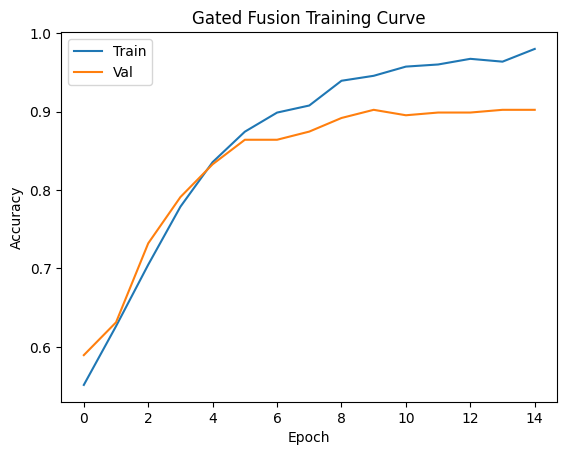

In [12]:
plt.figure()
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Gated Fusion Training Curve")
plt.show()

In [15]:
model.eval()
batch = next(iter(val_loader))

with torch.no_grad():
    img = batch['image_emb'].to(DEVICE)
    depth = batch['depth_emb'].to(DEVICE)
    text = batch['text_emb'].to(DEVICE)

gates = model.compute_gates(img, depth, text)

print("Gate weights (image, depth, text):")
print(gates[:5])

Gate weights (image, depth, text):
tensor([[[0.2720, 0.6448, 0.3186,  ..., 0.6728, 0.2860, 0.5850],
         [0.1025, 0.1596, 0.1060,  ..., 0.1073, 0.1953, 0.2440],
         [0.6255, 0.1956, 0.5754,  ..., 0.2199, 0.5187, 0.1711]],

        [[0.3602, 0.7945, 0.2056,  ..., 0.5826, 0.1798, 0.5307],
         [0.1313, 0.0925, 0.1084,  ..., 0.1599, 0.1723, 0.2870],
         [0.5085, 0.1130, 0.6861,  ..., 0.2575, 0.6479, 0.1824]],

        [[0.2948, 0.6140, 0.3067,  ..., 0.6888, 0.1957, 0.5231],
         [0.1139, 0.1681, 0.1112,  ..., 0.1243, 0.2187, 0.3079],
         [0.5913, 0.2180, 0.5821,  ..., 0.1869, 0.5857, 0.1690]],

        [[0.2539, 0.7377, 0.2706,  ..., 0.6443, 0.1657, 0.5375],
         [0.1250, 0.1349, 0.0994,  ..., 0.1259, 0.1713, 0.2778],
         [0.6211, 0.1273, 0.6300,  ..., 0.2297, 0.6630, 0.1847]],

        [[0.3141, 0.6385, 0.2467,  ..., 0.6363, 0.2201, 0.5109],
         [0.1541, 0.1604, 0.1068,  ..., 0.1617, 0.1625, 0.3079],
         [0.5319, 0.2011, 0.6465,  ..., 0.2021,

In [17]:
final_val_acc = evaluate(model, val_loader, DEVICE)
print("Final Validation Accuracy:\n", final_val_acc)

Final Validation Accuracy:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.85      0.92        13
           2       0.95      0.97      0.96        73
           4       0.00      0.00      0.00         1
           5       0.50      0.25      0.33         4
           6       0.88      1.00      0.93        14
           8       0.96      1.00      0.98        91
          10       0.00      0.00      0.00         5
          11       1.00      1.00      1.00         8
          13       0.71      1.00      0.83        10
          14       0.67      0.67      0.67         3
          17       0.71      0.89      0.79        19
          18       0.00      0.00      0.00         1
          19       0.50      0.50      0.50         2
          20       0.00      0.00      0.00         2
          21       0.00      0.00      0.00         3
          22       0.86      0.67      0.75         9

/Users/kmn/Documents/NNDL/Project/DepthAware/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/kmn/Documents/NNDL/Project/DepthAware/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/kmn/Documents/NNDL/Project/DepthAware/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio


Ablation: image_only
Accuracy: 0.8772563176895307

Ablation: depth_only
Accuracy: 0.3862815884476534

Ablation: text_only
Accuracy: 0.7581227436823105

Ablation: image_depth
Accuracy: 0.8736462093862816

Ablation: image_text
Accuracy: 0.9097472924187726

Ablation: depth_text
Accuracy: 0.7978339350180506

Ablation: all_modalities
Accuracy: 0.9061371841155235

Ablation Summary:
   image_only   → Accuracy: 0.8773
   depth_only   → Accuracy: 0.3863
   text_only    → Accuracy: 0.7581
   image_depth  → Accuracy: 0.8736
   image_text   → Accuracy: 0.9097
   depth_text   → Accuracy: 0.7978
   all_modalities → Accuracy: 0.9061


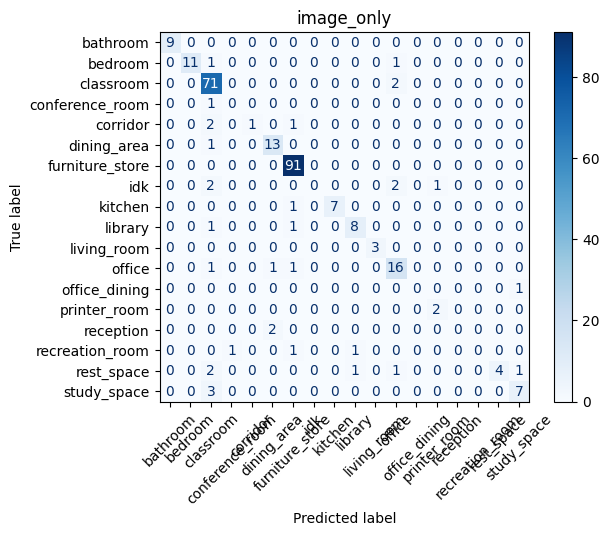

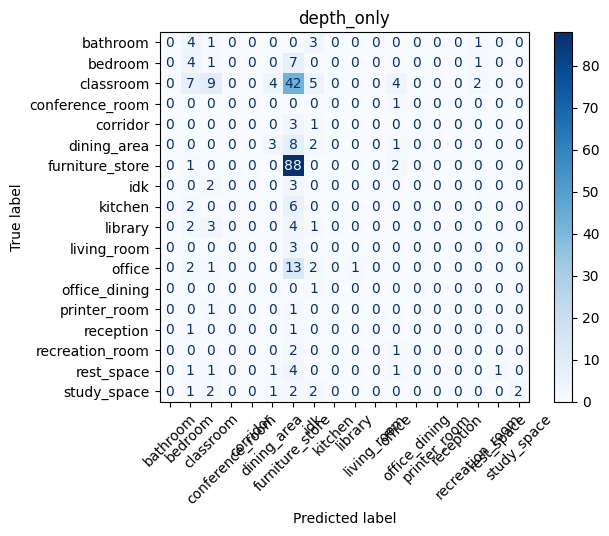

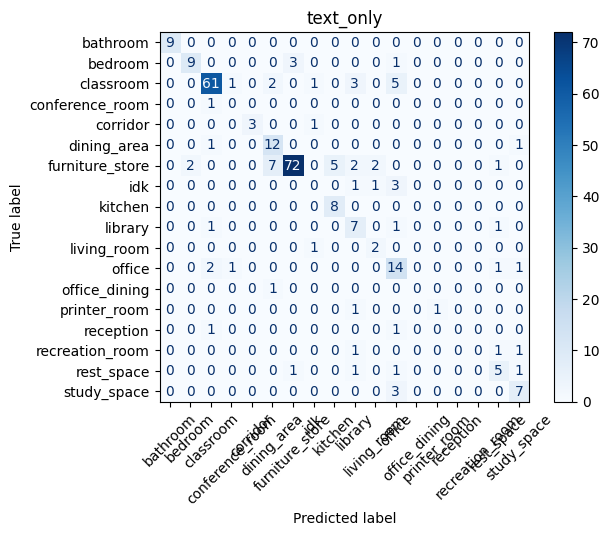

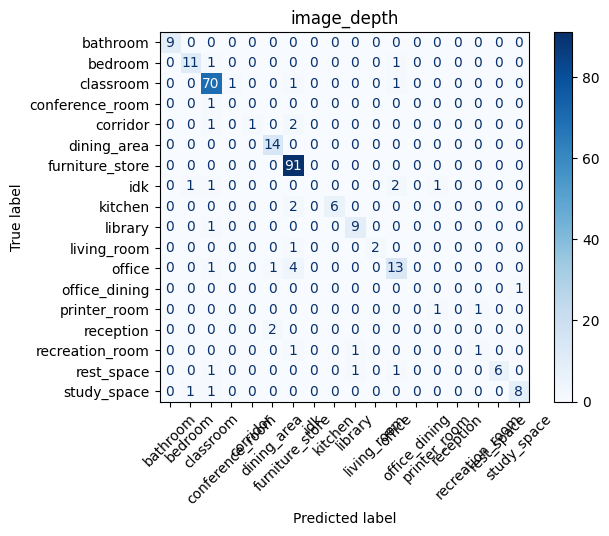

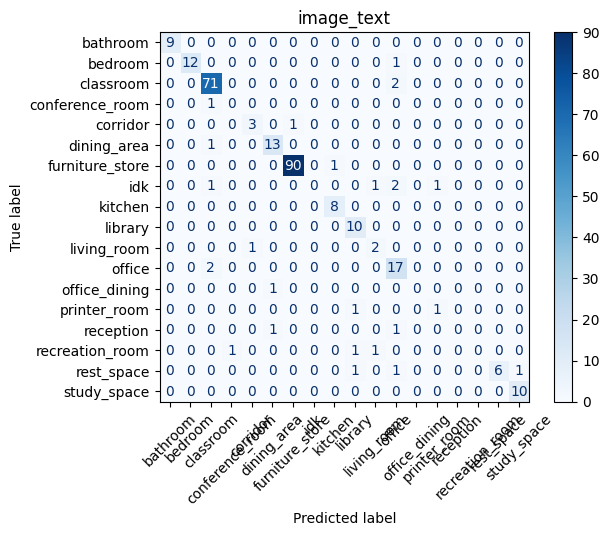

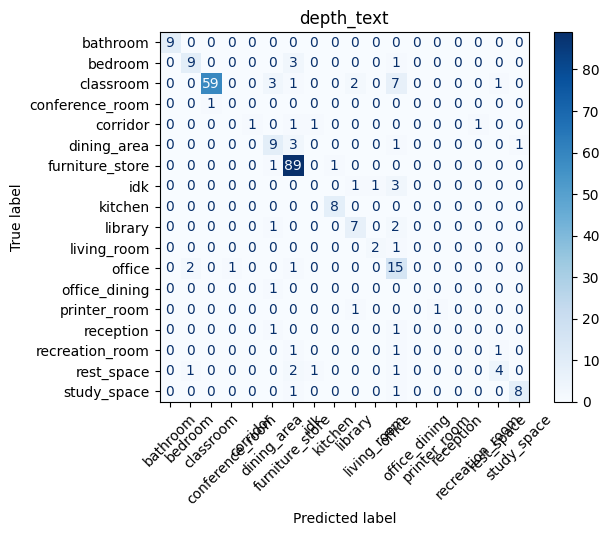

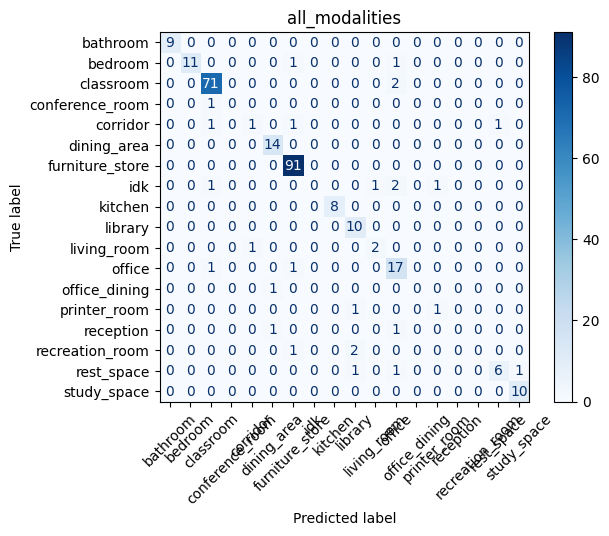

In [ ]:
from sceneclassification.ablations import ABLATION_CONFIGS, evaluate_with_ablation
from sceneclassification.eval import plot_confusion_matrix
import numpy as np

results = {}

for name, ablate in ABLATION_CONFIGS.items():
    print(f"\nAblation: {name}")

    # Evaluate the model with the specified ablation
    out = evaluate_with_ablation(
        model=model,
        dataloader=val_loader,
        device=DEVICE,
        ablate_modalities=ablate,
    )

    results[name] = out["accuracy"]
    print("Accuracy:", out["accuracy"])

    cm = out["confusion_matrix"]
    y_true = out["y_true"]

    # Dynamically determine class labels actually present in this evaluation
    unique_labels = np.unique(y_true)
    class_names = dataset.label_encoder.inverse_transform(unique_labels)

    plot_confusion_matrix(
        cm,
        class_names=class_names,
        title=name,
    )

print("\nAblation Summary:")
for k, v in results.items():
    print(f"   {k:<12} → Accuracy: {v:.4f}")

In [19]:
df_results = pd.DataFrame.from_dict(
    results, orient="index", columns=["accuracy"]
).sort_values("accuracy", ascending=False)

df_results

,accuracy
image_text,0.909747
all_modalities,0.906137
image_only,0.877256
image_depth,0.873646
depth_text,0.797834
text_only,0.758123
depth_only,0.386282
